In [1]:
import logging
import os
from slimit.lexer import Lexer
from calmjs.parse.lexers.es5 import Lexer as ES5Lexer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import manifold
from sklearn.model_selection import LeaveOneOut
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [2]:
from dotenv import load_dotenv
load_dotenv()

os.chdir(os.getenv("PROJECT_ROOT_DIR"))
print(os.getcwd())

/home/truonghm/learning/m1-internship/malicious-code-detection


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from lib.dataset import CodeDirectoryCorpus

In [5]:
corpus = CodeDirectoryCorpus('data/all/kaggle1', exclude_pattern="badHTML", sampling=1, seed=42)

/home/truonghm/learning/m1-internship/malicious-code-detection/lib/dataset.py:118: RuntimeWarning: Disabled dictionary initialization
  warnings.warn("Disabled dictionary initialization", RuntimeWarning)


In [6]:
len(corpus)

/home/truonghm/learning/m1-internship/malicious-code-detection/lib/dataset.py:111: RuntimeWarning: This is only an approximate length, since there might be errors in the corpus leading to some files not being read
  warnings.warn(


599

In [7]:
Y = corpus.labels

In [8]:
import torch.nn as nn
import torch

class CNNTextClassifier(nn.Module):
    def __init__(self, pretrained_embeddings, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()

        embedding_dim = pretrained_embeddings.shape[1] # Extract the embedding dimension from the pretrained embeddings

        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs, embedding_dim)) for fs in filter_sizes])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text = [batch size, sent len]
        embedded = self.embedding(text).unsqueeze(1)
        # embedded = [batch size, 1, sent len, emb dim]
        conved = [nn.ReLU()(conv(embedded)).squeeze(3) for conv in self.convs]
        # conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        pooled = [nn.MaxPool1d(conv.shape[2])(conv).squeeze(2) for conv in conved]
        # pooled_n = [batch size, n_filters]
        cat = self.dropout(torch.cat(pooled, dim=1))
        # cat = [batch size, n_filters * len(filter_sizes)]
        return self.fc(cat)



In [9]:
from gensim.models import Word2Vec

def get_token_type(corpus):
    codes = []
    for code in corpus.get_texts():
        codes.append([token[0] for token in code.tokens])
    return codes

# Train Word2Vec model
model_w2v = Word2Vec(sentences=get_token_type(corpus), vector_size=100, window=5, min_count=1, workers=4)

# Create a vocabulary mapping and an embedding matrix
vocab = {word: index for index, word in enumerate(model_w2v.wv.index_to_key)}
embedding_matrix = torch.FloatTensor(model_w2v.wv.vectors)

def encode_and_pad(tokens, vocab, max_length):
    encoded = [vocab[token] for token in tokens if token in vocab]
    padded = encoded + [0] * (max_length - len(encoded))
    return torch.LongTensor(padded)


data/all/kaggle1/badjs/ba6349fc4dae95c44bae9734389a33d5772da2d5371d0ea67523259b0ff684d4: Line 513: Unexpected token ILLEGAL
data/all/kaggle1/badjs/7b5c44ef97e427f3773a139d12bbb9b9cfaf8b3d33e646d32d935c35201b3f51: Line 170: Unexpected token ILLEGAL
data/all/kaggle1/badjs/08429caebcd57417c6cda0025dec858fb06f77d6cacf406076546dc6477d04e3: Line 27: Unexpected token ILLEGAL
data/all/kaggle1/badjs/b27b8e73e8ff706b91ea9b951eb0d22766abeab62ba8463e17b95e2572dd6513: Line 476: Unexpected token ILLEGAL
data/all/kaggle1/badjs/be607a8a2a03016bfab343b67bf6e297f50d79227c8ae9f4c89b722d81ea00db: Line 4: Unexpected token ILLEGAL
data/all/kaggle1/badjs/f2027862d050608be1ca74fd5137cf0d687c8450c7d12c772871a32b1e5aa7a0: Line 513: Unexpected token ILLEGAL
data/all/kaggle1/badjs/f2af5d1d964ccac03c6ae66d419996cb34c93b9d2917d1987b3bf86b78281ae7: Line 170: Unexpected token ILLEGAL
data/all/kaggle1/badjs/accbdefcd7ef59c63098ba69864c4b8272312814a475d06ccf8f9e1ac84b4faf: Line 513: Unexpected token ILLEGAL
data/all/ka

In [10]:
from torch.utils.data import DataLoader, Dataset

class CodeSnippetDataset(Dataset):
    def __init__(self, tokens, labels, vocab, max_length):
        self.samples = [encode_and_pad(token, vocab, max_length) for token in tokens]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        return self.samples[index], self.labels[index]

# Define a max_length based on your data
max_length = 200

# Define your X and Y data
tokens = [code_snippet.tokens for code_snippet in corpus.get_texts()]
Y = torch.tensor(Y) # Your labels

# Convert tokens to dataset
dataset = CodeSnippetDataset(tokens, Y, vocab, max_length)

# Split into train and test (or use your existing split)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.8), len(dataset) - int(len(dataset) * 0.8)])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

data/all/kaggle1/badjs/ba6349fc4dae95c44bae9734389a33d5772da2d5371d0ea67523259b0ff684d4: Line 513: Unexpected token ILLEGAL
data/all/kaggle1/badjs/7b5c44ef97e427f3773a139d12bbb9b9cfaf8b3d33e646d32d935c35201b3f51: Line 170: Unexpected token ILLEGAL
data/all/kaggle1/badjs/08429caebcd57417c6cda0025dec858fb06f77d6cacf406076546dc6477d04e3: Line 27: Unexpected token ILLEGAL
data/all/kaggle1/badjs/b27b8e73e8ff706b91ea9b951eb0d22766abeab62ba8463e17b95e2572dd6513: Line 476: Unexpected token ILLEGAL
data/all/kaggle1/badjs/be607a8a2a03016bfab343b67bf6e297f50d79227c8ae9f4c89b722d81ea00db: Line 4: Unexpected token ILLEGAL
data/all/kaggle1/badjs/f2027862d050608be1ca74fd5137cf0d687c8450c7d12c772871a32b1e5aa7a0: Line 513: Unexpected token ILLEGAL
data/all/kaggle1/badjs/f2af5d1d964ccac03c6ae66d419996cb34c93b9d2917d1987b3bf86b78281ae7: Line 170: Unexpected token ILLEGAL
data/all/kaggle1/badjs/accbdefcd7ef59c63098ba69864c4b8272312814a475d06ccf8f9e1ac84b4faf: Line 513: Unexpected token ILLEGAL
data/all/ka

/tmp/ipykernel_2182236/1291262144.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.long)


Epoch: 1, Train Accuracy: 0.4917, Val Accuracy: 0.3351
Epoch: 2, Train Accuracy: 0.4979, Val Accuracy: 0.3351
Epoch: 3, Train Accuracy: 0.4750, Val Accuracy: 0.3351
Epoch: 4, Train Accuracy: 0.4424, Val Accuracy: 0.6649
Epoch: 5, Train Accuracy: 0.4660, Val Accuracy: 0.3351
Epoch: 6, Train Accuracy: 0.4965, Val Accuracy: 0.3351
Epoch: 7, Train Accuracy: 0.4750, Val Accuracy: 0.6649
Epoch: 8, Train Accuracy: 0.5271, Val Accuracy: 0.3351
Epoch: 9, Train Accuracy: 0.5132, Val Accuracy: 0.3351
Epoch: 10, Train Accuracy: 0.4778, Val Accuracy: 0.6649


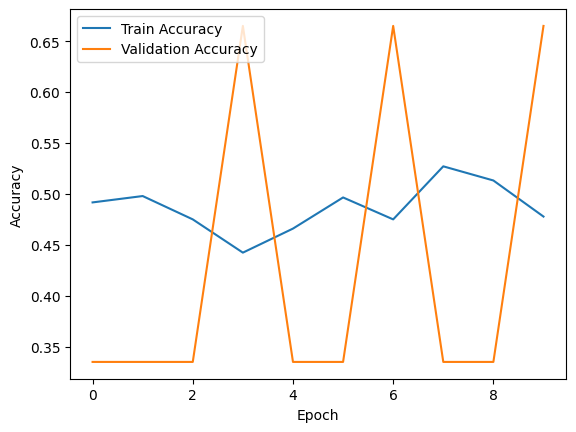

In [11]:
# Hyperparameters
n_filters = 100
filter_sizes = [2, 3, 4, 5]
output_dim = 2 # Number of classes
dropout = 0.5

# Create the CNN model
model = CNNTextClassifier(embedding_matrix, n_filters, filter_sizes, output_dim, dropout)

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)

model.apply(init_weights)

# Define loss function and optimizer
lr = 0.0001 # Try different values like 0.0001, 0.001, 0.01, etc.
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def calculate_accuracy(predictions, labels):
    preds = torch.argmax(predictions, dim=1)
    correct = (preds == labels).float()
    return correct.sum() / len(correct)

# Tracking accuracy
train_accuracies = []
val_accuracies = []

epochs = 10
for epoch in range(epochs):
    model.train()
    train_accuracy = []
    for batch in train_loader:
        text, labels = batch
        labels = labels.long()
        optimizer.zero_grad()
        predictions = model(text)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        train_accuracy.append(calculate_accuracy(predictions, labels))
    train_accuracies.append(sum(train_accuracy) / len(train_accuracy))

    # Validation accuracy
    model.eval()
    val_accuracy = []
    with torch.no_grad():
        for batch in test_loader:
            text, labels = batch
            labels = labels.long()
            predictions = model(text)
            val_accuracy.append(calculate_accuracy(predictions, labels))
    val_accuracies.append(sum(val_accuracy) / len(val_accuracy))

    print(f'Epoch: {epoch+1}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}')

# Plotting accuracy
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()